# Optimization of DAMIC CCDs Using Machine Learning

### Goal

This document will follow the development of a program which will be used to optimize DAMIC CCDs using machine learning.  The program will use Alex Piers' code to find relevant variables which can be used to determine the quality of any given image.  It will be able to map these parameters which determine the images' quality to the input parameters used to configure the CCD or to combinations of the parameters.  This will help identify which parameters or combinations of parameters are most relevant to image quality, which will allow us to build a model for image quality using machine learning.  Once we have a method for creating good models, we should be able to use it to optimize CCDs.

In [1]:
#Data handling packages
import pandas as pd
import numpy as np

#Plotting packages
import matplotlib.pyplot as plt
import seaborn as sns


### Convirt .fits files to .csv

To make analysis of these input and output variables, we don't want to be moving around all the raw data for each image since we will only be using processed data.  That means the first step will be to make a csv file for each CCD, containing the input and output variables of each image.  Later analysis will be done using the csv file.

The cell below runs FitsToCSV.py on the specified directory and all subdirectories it contains.  If the data is outside the folder, the argument should be the whole filepath to get to the directory.  Directories should be of the form "UW(4 digits)S" or "YYYY-MM-DD".  It will convirt every Img+//.fits file contained in the directory or subdirectories into a line in the csv output file.  The program may take several minutes to compile, depending on how large the directory is that one is analyzing.

In [1]:
!python FitsToCSV.py "UW1032S"

UW1032S
  0%|                                                     | 0/4 [00:00<?, ?it/s]Reading images from: UW1032S
/home/shda/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
100%|█████████████████████████████████████████████| 4/4 [00:06<00:00,  1.75s/it]


### Graphing Variables (1 Dimensional)

The first analysis we want to see from the .csv file is the relation between 2 variables.  The code cell below takes two variable names as arguments, and shows the relation between them in a scatter plot.  The first argument will be the .csv file, the second argument will be the variable appearing on the x axis, and the third will appear on the y.

Key to Variables:

Inputs:
'EXP', 'AMPL', 'HCKDIRN', 'VCKDIRN', 'ITGTIME', 'VIDGAIN', 'PRETIME', 'POSTIME', 'DGWIDTH', 'RGWIDTH', 'OGWIDTH', 'SWWIDTH', 'HWIDTH', 'HOWIDTH', 'VWIDTH', 'VOWIDTH', 'ONEVCKHI', 'ONEVCKLO', 'TWOVCKHI', 'TWOVCKLO', 'TGHI', 'TGLO', 'HUHI', 'HULO', 'HLHI', 'HLLO', 'RGHI', 'RGLO', 'SWLO', 'DGHI', 'DGLO', 'OGHI', 'OGLO', 'BATTR', 'VDD1', 'VDD2', 'DRAIN1', 'DRAIN2', 'VREF1', 'VREF2', 'OPG1', 'OPG2'.

Outputs:
'imgNoise', 'skNoise', 'aveImgS', 'dSdskip', 'pixVar', 'clustVar', 'tailRatio', 'DC'.

Image info:
'NDCMS', 'NAXIS1', 'NAXIS2'.

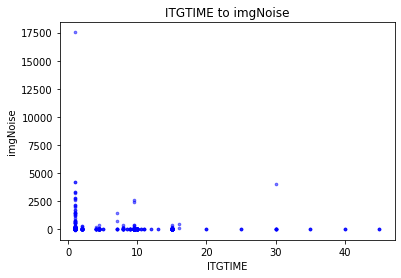

In [2]:
%matplotlib inline
import Graphing

Graphing.graph1D("UW1602S.csv","ITGTIME", "imgNoise")

### Transform CSV

Make a new .csv file which convirts image quality into one single metric, which consists of the magnitude of a vector whos components are dark current, noise, and charge transfer, each multiplied by a scalar which decides the weighting of each component.

Also, allows for quicker manipulation of the .csv files (it takes a long time to read .fits files). 

In [ ]:
import TransformCSV

fileTransform = "UW1608S.csv"

TransformCSV.transformCSV(fileTransform, "T-" + fileTransform)

In [2]:
# Generate ccd dataframe

ccdraw = pd.read_csv("T-UW1602S.csv")

### Transform Dataframe

Takes a dataframe of images and manipulates the data to output a new dataframe.

Currently this program:

- takes a ccd dataframe and removes colums which only contain 1 value or the error value, and thus cannot be used to find trends.

In [3]:
import TransformDataFrame

ccd = TransformDataFrame.remove_unhelpful(ccdraw)

### Deciding Which Variables are Usable

If variables are only ever set to 1 or 2 values then they should not be considered usable in the analysis.

The following plots bins of histograms of the values assigned to each variable, which allows one to see their distribution.

/home/shda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


30


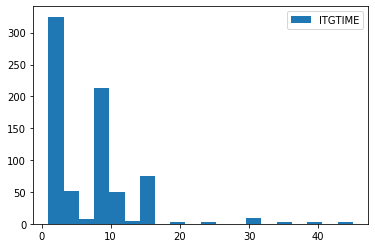

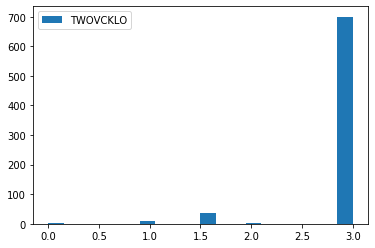

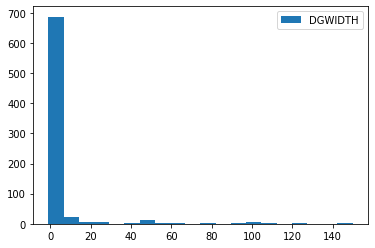

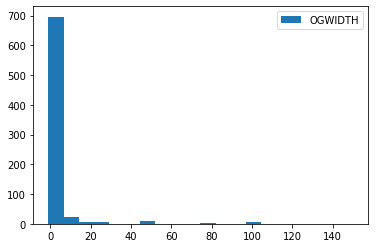

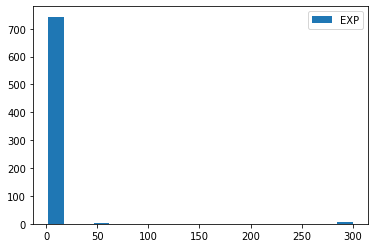

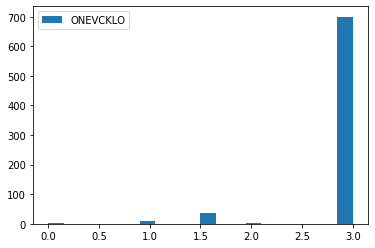

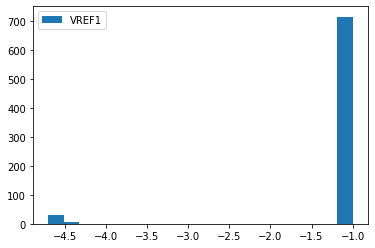

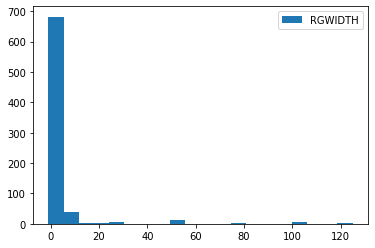

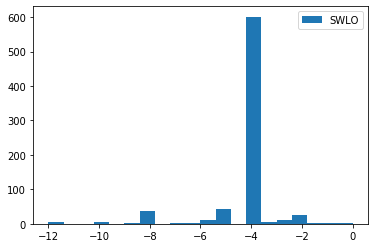

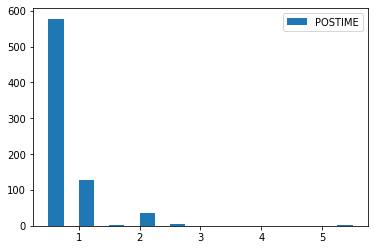

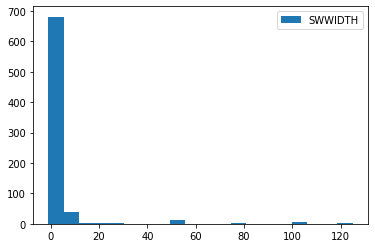

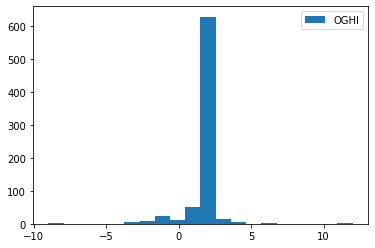

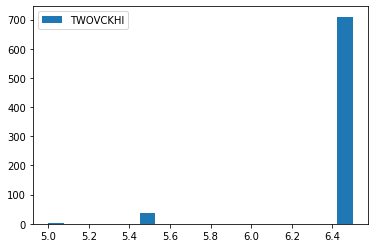

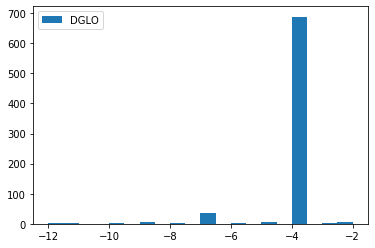

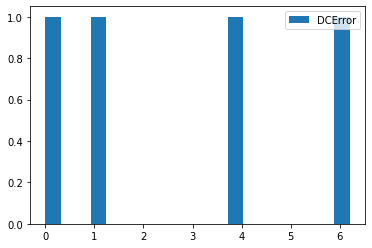

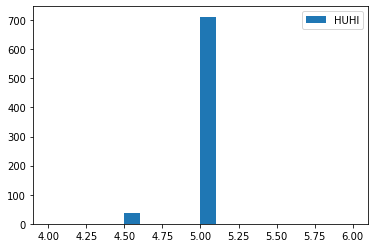

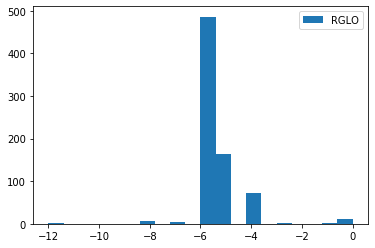

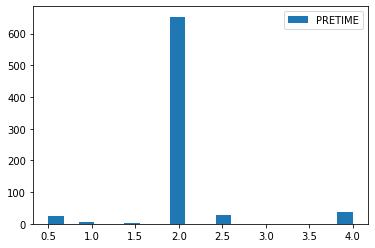

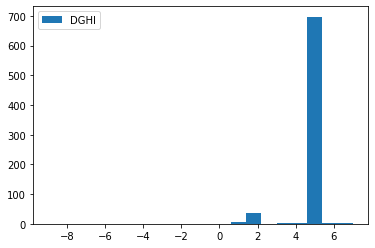

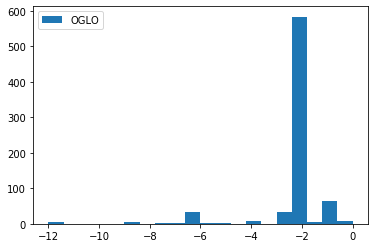

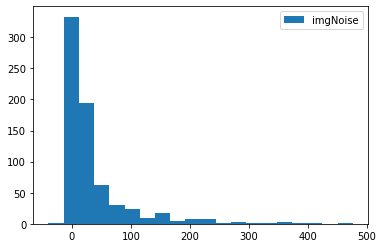

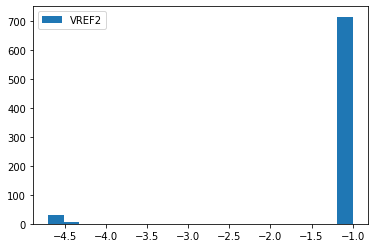

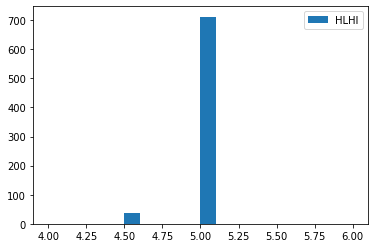

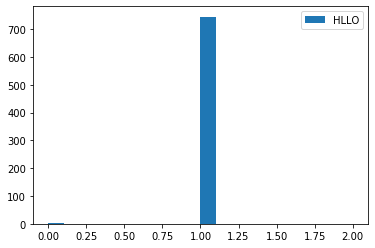

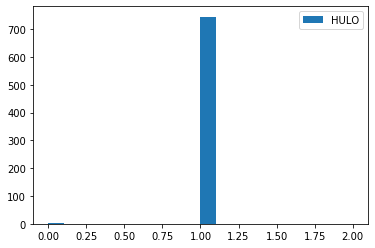

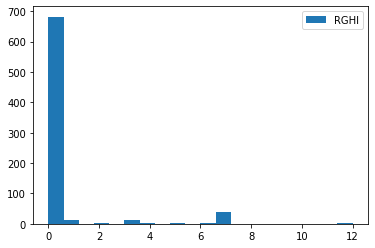

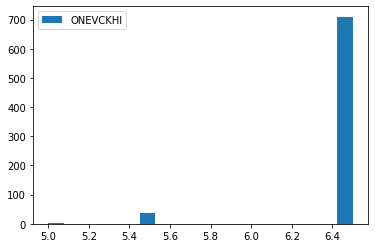

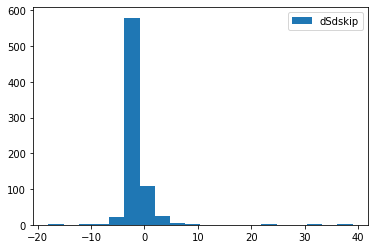

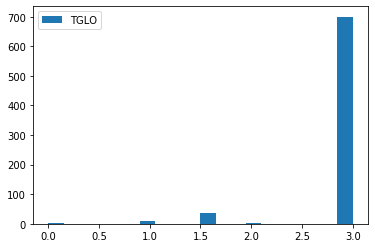

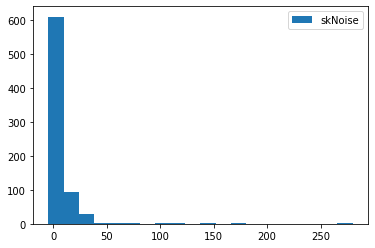

In [9]:
headers = {'imgNoise', 'skNoise', 'dSdskip', 'DCError', 'EXP', 'ITGTIME', 'VIDGAIN', 'PRETIME', 'POSTIME', 'DGWIDTH', 'RGWIDTH', 'OGWIDTH', 'SWWIDTH', 'HWIDTH', 'HOWIDTH', 'VWIDTH', 'VOWIDTH', 'ONEVCKHI', 'ONEVCKLO', 'TWOVCKHI', 'TWOVCKLO', 'TGHI', 'TGLO', 'HUHI', 'HULO', 'HLHI', 'HLLO', 'RGHI', 'RGLO', 'SWLO', 'DGHI', 'DGLO', 'OGHI', 'OGLO', 'BATTR', 'VDD1', 'VDD2', 'DRAIN1', 'DRAIN2', 'VREF1', 'VREF2', 'OPG1', 'OPG2'}

count = 0

for header in list(headers.intersection(ccd.columns)):
    
    plt.figure()
    
    dat = np.array(ccd[header])
    plt.hist([i for i in dat if -500 < i < 500], bins=20, label = header)
    plt.legend()
    count += 1
    
print(count)


### Finding Direct Correlations Between Variables

To get a better idea about how variables affect each other, we need a way to look at correlations between input and output variables, which turns out to be relativley straight forward using pandas and seaborn.

We can create a heat map of the correlation matrix so that we can easily see the relevant relations.

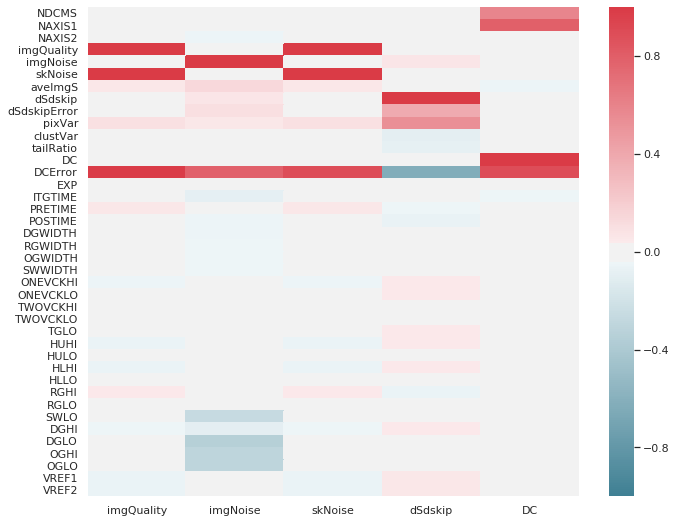

In [4]:
outvars = {'imgQuality', 'DC', 'dSdskip','skNoise', 'imgNoise'}

outvars = list((ccd.columns).intersection(outvars))

sns.set(style="white")

# Generate a mask for the upper triangle
#mask = (np.isnan(corr['DC']))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio

sns.heatmap(ccd.corr()[outvars], cmap=cmap, vmin = -1, vmax = 1)

### Linear Combinations of Variables

Direct correlations will not tell us enough about the data since, as we know from using the CCDs, in some cases linear combinations of variables are more important than the variables themselves.

To easily try linear combinations we might suspect to be significant, this program generates a panel of sliders that output a heat map showing the correlation between your chosen combo, and the output variables.  Note that the only relevant column is the leftmost column.  I would output just this column, but seaborn (and matplotlib) heatmaps will not plot a single column of data, and wanted to keep using seaborn because I'd rather not just display the numbers.

Notes for use:
  - To reset sliders run the code cell again.
  - The sliders are only easily usable when the window is in full screen.
  - Seaborn has some issues working with Matplotlib 3.1.1, so for best performance use 3.1.0.  However, it should still work with 3.1.1.
  - You can use the above correlation map as a starting point

In [7]:
%matplotlib inline
import LinearComboSliders

LinearComboSliders.interact_combo(ccdraw)

Output()